In [1]:
import torch
print(torch.cuda.device_count())

1


## Load Google's pretrained word2vec model 

In [2]:
"""
imports
"""
import numpy as np
import gensim                             # belongs to gensim package
from smart_open import open as smart_open # belongs to smart_open package

"""
load model, located in a 'models' folder
download it yourself, and do not put it in the github repo
(i.e. put it in your .gitignore file) because it's YUGE
download: https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit?usp=sharing
"""
with smart_open('./models/GoogleNews-vectors-negative300.bin', 'rb') as word2vec_file:
    word2vec = gensim.models.KeyedVectors.load_word2vec_format(word2vec_file, binary=True)

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [3]:
"""
Putting model to use
notes:
 - model is made to produce 300D vectors
 - can't turn vectors into words
"""
word2vec.get_vector("hi")
word2vec.get_vector("Yagmur")

array([ 0.0612793 , -0.01312256, -0.02307129, -0.04736328,  0.02270508,
        0.12695312, -0.06396484, -0.22949219, -0.01116943,  0.04931641,
       -0.01977539, -0.06738281, -0.18457031,  0.02856445, -0.06445312,
       -0.07861328, -0.04321289, -0.08300781, -0.10009766, -0.08496094,
       -0.01409912,  0.12109375,  0.01855469,  0.03051758,  0.00610352,
       -0.11865234,  0.08105469, -0.01220703,  0.09716797, -0.16992188,
       -0.1171875 , -0.12011719,  0.10302734,  0.05249023, -0.01904297,
       -0.01696777, -0.11669922,  0.16503906, -0.10986328,  0.04785156,
        0.13769531, -0.00488281, -0.0534668 , -0.08789062,  0.12890625,
       -0.05029297, -0.12890625, -0.13769531, -0.03833008, -0.07226562,
       -0.10351562,  0.03930664,  0.07714844,  0.03686523,  0.0402832 ,
        0.05834961,  0.03442383,  0.17578125,  0.0324707 , -0.04882812,
        0.00497437, -0.078125  ,  0.02050781, -0.01116943,  0.14160156,
        0.00282288,  0.22851562, -0.05078125,  0.08642578, -0.02

## Load the arxiv data

In [4]:
import json
DATAPATH = "data/articles.json"

with open(DATAPATH, "r", encoding="utf-8") as f:
    articles = json.load(f)
    
from random import shuffle    
shuffle(articles)
    
from sklearn.model_selection import train_test_split
train_articles, test_articles = train_test_split(articles, train_size=.9, test_size=.1)
    
categories = list(set([article['category'] for article in articles]))

## Turning abstracts into pytorch tensors

In [5]:
import torch
import string
import unicodedata
import re

tokenize = lambda x: re.sub("[^\w'-]", " ",  x).split()

def lineToTensor(text):
    words = tokenize(text)
    vectors = []
    for word in words:
        try:
            vector = word2vec.get_vector(word)
            vectors.append(vector)
        except:
            pass
        
    #create 3D tensor with the shape which is proper for the LSTM
    if not vectors:
        raise Exception("This line did not produce any embedded words!")
    
    return torch.tensor([[v] for v in vectors])

## Creating the RNN architecture

In [6]:
import torch.nn as nn

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM, self).__init__()

        self.hidden_size = hidden_size
        
        self.i2h = nn.LSTM(input_size, hidden_size, 1)
        
        
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input):
        hidden , (h_t, c_t) = self.i2h(input)
        output = self.h2o(hidden[-1])
        output = self.softmax(output)
        return output


input_size = 300
hidden_size = 300
output_size = len(categories)

rnn=LSTM(input_size=input_size,hidden_size=hidden_size, output_size=len(categories))
rnn.cuda()

LSTM(
  (i2h): LSTM(300, 300)
  (h2o): Linear(in_features=300, out_features=8, bias=True)
  (softmax): LogSoftmax()
)

## Preparing for training

In [7]:
def categoryFromOutput(out):
    top_n, top_i = out.topk(1)
    category_i = top_i[0].item()
    return categories[category_i], category_i

print(categoryFromOutput(rnn(lineToTensor("some random line here").cuda())))

('Physics', 3)


In [10]:
from random import choice

train_articles_organized = {category: [] for category in categories}
for article in train_articles:
    train_articles_organized[article['category']].append(article)

def randomTrainingExample():
    category = choice(list(train_articles_organized.keys()))
    article = choice(train_articles_organized[category])
    # category = article['category']
    category_tensor = torch.tensor([categories.index(category)], dtype=torch.long)
    abstract = article["abstract"]
    abstract_tensor = lineToTensor(abstract)
    return category, abstract, category_tensor, abstract_tensor

randomTrainingExample()

('Quantitative Finance',
 "We propose a continuous time model for financial markets with proportional\ntransactions costs and a continuum of risky assets. This is motivated by bond\nmarkets in which the continuum of assets corresponds to the continuum of\npossible maturities. Our framework is well adapted to the study of no-arbitrage\nproperties and related hedging problems. In particular, we extend the\nFundamental Theorem of Asset Pricing of Guasoni, R\\'asonyi and L\\'epinette\n(2012) which concentrates on the one dimensional case. Namely, we prove that\nthe Robust No Free Lunch with Vanishing Risk assumption is equivalent to the\nexistence of a Strictly Consistent Price System. Interestingly, the presence of\ntransaction costs allows a natural definition of trading strategies and avoids\nall the technical and un-natural restrictions due to stochastic integration\nthat appear in bond models without friction. We restrict to the case where\nexchange rates are continuous in time and le

## Training the network

In [11]:
import torch.optim as optim

learning_rate = 0.005

criterion = nn.NLLLoss()
optimizer = optim.SGD(rnn.parameters(), lr = learning_rate, momentum = 0.9)

def train(category_tensor, abstract_tensor):
    optimizer.zero_grad()
    
    output = rnn(abstract_tensor.cuda())
            
    loss = criterion(output, category_tensor.cuda())
    loss.backward()
    optimizer.step()
        
    return output, loss.item()

In [ ]:
import time

n_iters = 200000
print_every = 100
plot_every = 10

# keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = s//60
    s -= m*60
    return "{}m {}s".format(m, s)

start = time.time()

for it in range(1, n_iters+1):
    try:
        category, line, category_tensor, line_tensor = randomTrainingExample()
    except:
        continue
        
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss
    
    if not (it % print_every):
        guess, guess_i = categoryFromOutput(output)
        correct = "V" if guess == category else "X {}".format(category)
        print("{} {}% ({}) {:.4} / {} {}".format(it, it/n_iters*100, timeSince(start), loss, guess, correct))
        
    if not (it % plot_every):
        all_losses.append(current_loss / plot_every)
        current_loss = 0

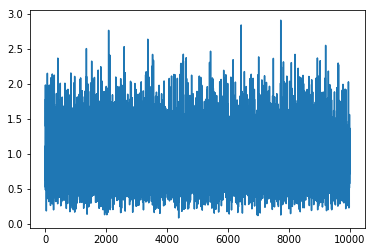

In [29]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(all_losses)
plt.show()

### Serializing, then deserializing the model

In [42]:
word2vec_rnn_model_path = './models/word2vec_rnn.bin' # I have no idea if this should be considered a binary file or not

In [43]:
# Serialize
# https://pytorch.org/tutorials/beginner/saving_loading_models.html
torch.save(rnn.state_dict(), word2vec_rnn_model_path)

In [32]:
# Deserialize
device = torch.device("cuda")
rnn = LSTM(input_size=input_size, hidden_size=hidden_size, output_size=output_size)
rnn.load_state_dict(torch.load(word2vec_rnn_model_path))
rnn.to(device)

LSTM(
  (i2h): LSTM(300, 300)
  (h2o): Linear(in_features=300, out_features=8, bias=True)
  (softmax): LogSoftmax()
)

### Testing our model

In [33]:
zzz = list(set([article['category'] for article in test_articles]))
zzz

['Quantitative Finance',
 'Quantitative Biology',
 'Economics',
 'Physics',
 'Mathematics',
 'Statistics',
 'Electrical Engineering and Systems Science',
 'Computer Science']

In [44]:
# make and plot a confusion matrix
from sklearn.metrics import confusion_matrix as get_confusion_matrix

y_true = []; y_pred = [];
labels = []
for article in test_articles[:]:
    label = article['category']
    if label not in labels: labels.append(label)

    y_true.append(label)
    pred, _ = categoryFromOutput(rnn(lineToTensor(article['abstract']).cuda()))
    y_pred.append(pred)

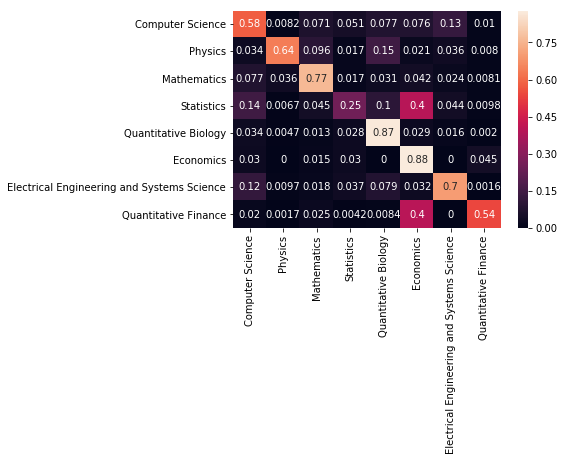

In [45]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

confusion_matrix = get_confusion_matrix(y_true=y_true, y_pred=y_pred, labels=labels)

df_cm = pd.DataFrame(confusion_matrix, index=labels, columns=labels)
df_cm_scaled = df_cm.apply(func=lambda x: x/x.sum(), axis=1)
plt.figure()
sns.heatmap(df_cm_scaled, annot=True)
plt.show()

In [37]:
# # serialize results for easy reanalysis later
# import pickle

# results = {
#     'labels': labels,
#     'confusion_matrix': confusion_matrix,
#     'y_pred': y_pred,
#     'y_true': y_true
# }

# pickle.dump(results, open('results_even.pickle', 'wb+'))

In [47]:
from sklearn.metrics import classification_report

report = classification_report(y_true = y_true,
                               y_pred = y_pred,
                               labels = labels)

print(report)

                                            precision    recall  f1-score   support

                          Computer Science       0.78      0.58      0.66     14330
                                   Physics       0.95      0.64      0.77     20695
                               Mathematics       0.79      0.77      0.78     15656
                                Statistics       0.28      0.25      0.27      2237
                      Quantitative Biology       0.31      0.87      0.46      2546
                                 Economics       0.02      0.88      0.03        66
Electrical Engineering and Systems Science       0.12      0.70      0.21       618
                      Quantitative Finance       0.58      0.54      0.56      1190

                                 micro avg       0.65      0.65      0.65     57338
                                 macro avg       0.48      0.65      0.47     57338
                              weighted avg       0.79      0.65      0.70 

In [60]:
z = test_articles[110]
a0 = z['abstract']
a1 = a0.replace('\n', ' ')

tensor([[[1, 1, 1,  ..., 1, 1, 1]],

        [[1, 1, 1,  ..., 1, 1, 1]],

        [[1, 1, 1,  ..., 1, 1, 1]],

        ...,

        [[1, 1, 1,  ..., 1, 1, 1]],

        [[1, 1, 1,  ..., 1, 1, 1]],

        [[1, 1, 1,  ..., 1, 1, 1]]], dtype=torch.uint8)
